In [33]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.time import Time
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from photutils import aperture_photometry, CircularAperture, CircularAnnulus



/var/folders/28/tbbt82d56sg9zc7jc4j4d7p40000gn/T/ipykernel_2783/1727402983.py:10: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry, CircularAperture, CircularAnnulus
/var/folders/28/tbbt82d56sg9zc7jc4j4d7p40000gn/T/ipykernel_2783/1727402983.py:10: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import aperture_photometry, CircularAperture, CircularAnnulus
/var/folders/28/tbbt82d56sg9zc7jc4j4d7p40000gn/T/ipykernel_2783/1727402983.py:10: DeprecationWarning: `photutils.CircularAnnulus` is a deprecated alias for `photutils.aperture.Circula

In [42]:
fits_directory = '/Users/wendy/Desktop/16stackhr'


In [43]:
target_coords = (2105.4637, 1745.8571)
reference_coords_list = [(1738.4472, 1928.3894), (1830.4074, 2965.5023)]


In [44]:
import os
fits_files = sorted(glob.glob(os.path.join(fits_directory, '*.fits')))


In [45]:
# Define the target's coordinates (x, y) and the aperture/annulus radii
aperture_radius = 16
annulus_inner_radius = 28
annulus_outer_radius = 41

time_array = []
flux_ratio_array = []

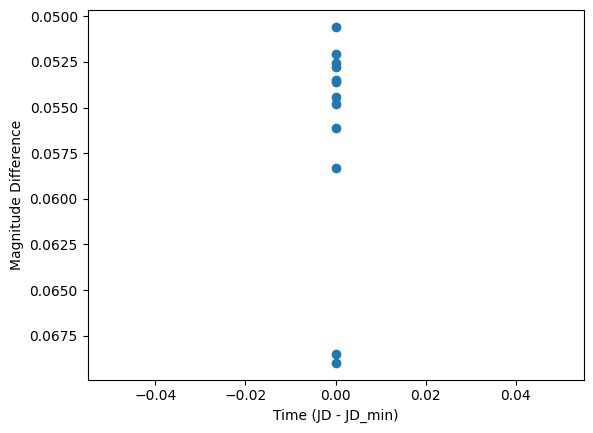

In [46]:
for file in fits_files:
    with fits.open(file) as hdulist:
        header = hdulist[0].header
        data = hdulist[0].data.astype(float)

        # Subtract the background
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)
        data -= median

        # Define the target apertures and annuli
        target_aperture = CircularAperture(target_coords, r=aperture_radius)
        target_annulus = CircularAnnulus(target_coords, r_in=annulus_inner_radius, r_out=annulus_outer_radius)

        # Perform aperture photometry for the target object
        target_phot = aperture_photometry(data, [target_aperture, target_annulus])

        # Calculate the background-subtracted flux for the target object
        target_bkg_mean = target_phot['aperture_sum_1'] / target_annulus.area
        target_flux = target_phot['aperture_sum_0'] - target_bkg_mean * target_aperture.area

        # Calculate the magnitude difference for each reference star
        mag_diff_list = []

        for ref_coords in reference_coords_list:
            # Define the reference star apertures and annuli
            ref_aperture = CircularAperture(ref_coords, r=aperture_radius)
            ref_annulus = CircularAnnulus(ref_coords, r_in=annulus_inner_radius, r_out=annulus_outer_radius)

            # Perform aperture photometry for the reference star
            ref_phot = aperture_photometry(data, [ref_aperture, ref_annulus])

            # Calculate the background-subtracted flux for the reference star
            ref_bkg_mean = ref_phot['aperture_sum_1'] / ref_annulus.area
            ref_flux = ref_phot['aperture_sum_0'] - ref_bkg_mean * ref_aperture.area

            # Calculate the magnitude difference
            mag_diff = -2.5 * np.log10(target_flux / ref_flux)
            mag_diff_list.append(mag_diff)

        # Calculate the average magnitude difference
        avg_mag_diff = np.mean(mag_diff_list)

        # Store the time and average magnitude difference
        time_array.append(Time(header['DATE-OBS']).jd)
        flux_ratio_array.append(avg_mag_diff)

# Normalize the time array
time_array = np.array(time_array) - min(time_array)

# Plot the light curve
plt.figure()
plt.plot(time_array, flux_ratio_array, 'o') 
plt.xlabel('Time (JD - JD_min)')
plt.ylabel('Magnitude Difference')
plt.gca().invert_yaxis()
plt.show()

SINGLE FITS FILE

In [31]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
from astropy.wcs import WCS


In [30]:
# Open the FITS file
file_name = '/Users/wendymendoza/Desktop/Yan/2023-03-16/stacked_5.fits'
with fits.open(file_name) as hdul:
    header = hdul[0].header
    data = hdul[0].data

In [32]:
# Assuming you have the header of your FITS file
header = hdul[0].header

# Create a WCS object using the header information
wcs = WCS(header)

# Define the target's RA and Dec (in degrees)
ra, dec = 152.9324407, 57.3038326  # Replace these with the actual RA and Dec


In [34]:
# Convert RA and Dec to pixel coordinates
x, y = wcs.all_world2pix(ra, dec, 1)  # 1 is for the origin (FITS-like)

# Convert numpy arrays to float and round the pixel coordinates to integers
x, y = int(round(float(x))), int(round(float(y)))


In [35]:
# Define the target's coordinates (x, y) and the aperture/annulus radii
r_aperture = 5
r_in, r_out = 10, 15


In [36]:
# Create the aperture and annulus objects
aperture = CircularAperture((x, y), r=r_aperture)
annulus = CircularAnnulus((x, y), r_in=r_in, r_out=r_out)

In [37]:
# Calculate the background level using the annulus
annulus_masks = annulus.to_mask(method='center')
annulus_data = annulus_masks.multiply(data)
annulus_data_1d = annulus_data[annulus_masks.data > 0]
_, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)

# Perform aperture photometry
phot = aperture_photometry(data, aperture)
phot['annulus_median'] = median_sigclip
phot['aper_bkg'] = median_sigclip * aperture.area
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']

# Print the results
print(phot['aper_sum_bkgsub']) 

 aper_sum_bkgsub  
------------------
-20.59005106832774
